In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the last date recorded
last_date_row = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date_row.date, '%Y-%m-%d')

In [11]:
# Calculate the date 1 year ago from the last data point in the database
yearago_date = last_date - dt.timedelta(days=365)

In [12]:
# Perform a query to retrieve the date and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= yearago_date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['date', 'precipitation'])
prcp_df.set_index("date", inplace=True)

In [14]:
# Sort the dataframe by date
prcp_df.sort_values("date", inplace=True)

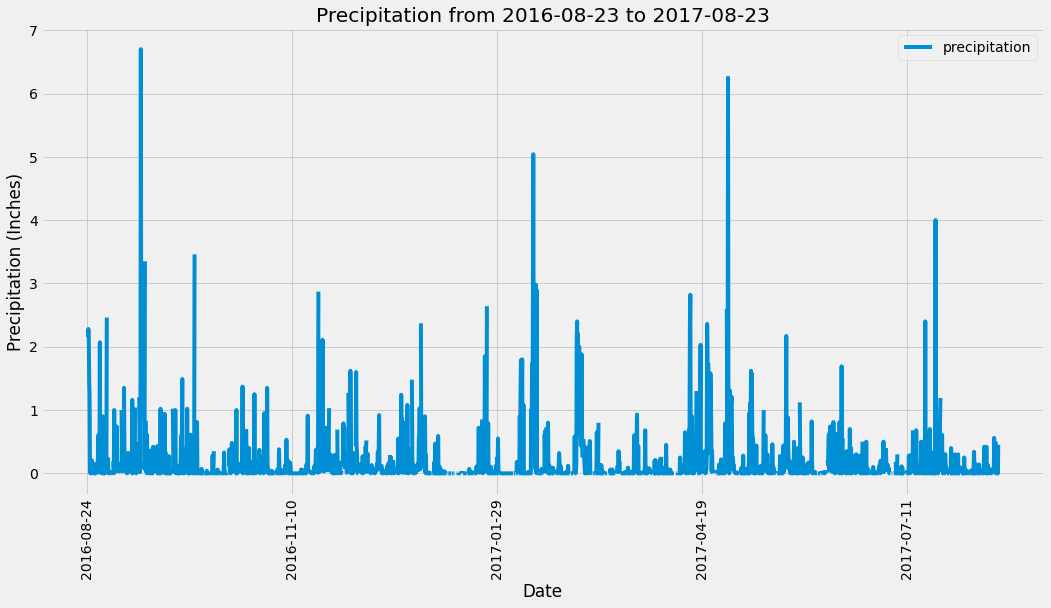

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=90, figsize=(16,8));
ax.set_title(f"Precipitation from {dt.datetime.strftime(yearago_date, '%Y-%m-%d')} to {dt.datetime.strftime(last_date, '%Y-%m-%d')}");
ax.set_ylabel("Precipitation (Inches)");
ax.set_xlabel("Date")
plt.savefig("Images/prcp.png",bbox_inches="tight", pad_inches=.3)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).scalar()
print(f"Number of Stations: {station_count}")

Number of Stations: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Station.name, Station.station, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_station_df = pd.DataFrame(active_station, columns=['name', 'station', 'count'])
active_station_df

,name,station,count
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Find the most active station
(station_name, station, station_count) = active_station[0]

station_stats = session.query(func.max(Measurement.tobs), 
                              func.min(Measurement.tobs), 
                              func.avg(Measurement.tobs)).\
    filter(Measurement.station == station).first()

(station_max_temp, station_min_temp, station_avg_temp) = station_stats

print(f"Most Active Station: {station_name} ({station})")
print(f"Max Temparature: {station_max_temp}F")
print(f"Min Temparature: {station_min_temp}F")
print(f"Average Temparature: {round(station_avg_temp,2)}F")


Most Active Station: WAIHEE 837.5, HI US (USC00519281)
Max Temparature: 85.0F
Min Temparature: 54.0F
Average Temparature: 71.66F


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the last date recorded
station_last_date_row = session.query(Measurement.date).\
    filter(Measurement.station == station).\
    order_by(Measurement.date.desc()).first()


In [21]:
# Calculate the date 1 year ago from the last data point in the database
station_last_date = dt.datetime.strptime(last_date_row.date, '%Y-%m-%d')
station_yearago_date = station_last_date - dt.timedelta(days=365)

In [22]:
# Perform a query to retrieve temperature 
results = session.query(Measurement.tobs).\
    filter(Measurement.date >= station_yearago_date).\
    filter(Measurement.station == station).all()
station_results = list(np.ravel(results))

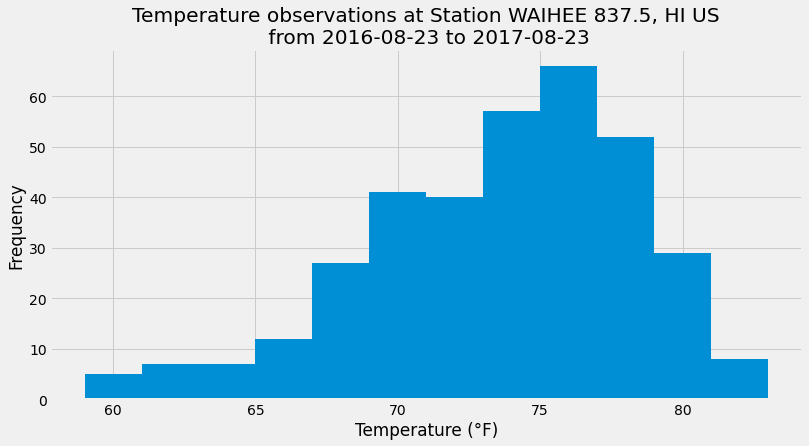

In [23]:
# Plot a histogram
plt.figure(figsize=(12,6))
plt.hist(station_results, bins=12)
plt.title(f"Temperature observations at Station {station_name}\n from {dt.datetime.strftime(station_yearago_date, '%Y-%m-%d')} to {dt.datetime.strftime(station_last_date, '%Y-%m-%d')}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.savefig("Images/temp_hist.png",bbox_inches="tight", pad_inches=.3)
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [24]:
# Find the temperature in June for all years
june_results = session.query(func.avg(Measurement.tobs)).\
                    filter(func.strftime("%m", Measurement.date) == "06").\
                    group_by(func.strftime("%Y", Measurement.date)).all()

dec_results = session.query(func.avg(Measurement.tobs)).\
                    filter(func.strftime("%m", Measurement.date) == "12").\
                    group_by(func.strftime("%Y", Measurement.date)).all()

# Find the temperature in Decemeber for all years
june_avg_temp = list(np.ravel(june_results))
dec_avg_temp = list(np.ravel(dec_results))

# Calculate Independent (Two Sample) t-test to determine 
# if there is a difference in the means
stats.ttest_ind(june_avg_temp, dec_avg_temp, equal_var=False)


Ttest_indResult(statistic=6.9218571747346616, pvalue=1.4518830376438732e-05)

### Observations

* I used an unpaired or Independent t-test since we are comapring two separate sets of independent samples. 

* The t-score is 6.92, which is small. This means that the 2 samples are similar.

* The p-value is 1.4518830376438732e-05, which is < 0.05. This means that here is a statistical difference between the June and December temperatures

### Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Ask for user's trip dates
# Check if date is in the correct format
check = True
while check:
    try:
        tstart_date = input(f"Enter trip start date: ")
        dt.datetime.strptime(tstart_date, "%Y-%m-%d")
        check = False
        
    except ValueError:
        print("Incorrect format. Please enter the date as YYYY-MM-DD")

check = True
while check:
    try:
        tend_date = input(f"Enter trip end date: ")
        dt.datetime.strptime(tend_date, "%Y-%m-%d")
        check = False
        
    except ValueError:
        print("Incorrect format. Please enter the date as YYYY-MM-DD")
        

Enter trip start date: 2012-09-09
Enter trip end date: 2012-09-13


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tstart_date = "2018-01-01"
tend_date = "2018-01-07"

trip_start_date = dt.datetime.strptime(tstart_date, '%Y-%m-%d')
trip_end_date = dt.datetime.strptime(tend_date, '%Y-%m-%d')

# Check if the trip start date is greater than the latest date in the dataset
if trip_start_date >= last_date:
    # Get the year of the latest date in data set
    last_date_year = last_date.year
    
    # replace the trip start date year with year of the latest date in data set
    # (i.e., use "2018-01-01" if your trip start date was "2021-01-01")
    start_date = str(last_date_year) + tstart_date[-6:]
    query_start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    
    # replace the trip end date year with year of the latest date in data set
    end_date = str(last_date_year) + tend_date[-6:]
    query_end_date = dt.datetime.strptime(end_date, '%Y-%m-%d') 

else:
    # Find the previous year dates
    query_start_date = trip_start_date - dt.timedelta(days=365)
    query_end_date = trip_end_date - dt.timedelta(days=365)

# call function `calc_temps` to calculate the tmin, tavg, and tmax 
trip_results = calc_temps(query_start_date, query_end_date)
(trip_min_temp, trip_avg_temp, trip_max_temp) = trip_results[0]
trip_results[0]

(62.0, 68.2, 74.0)

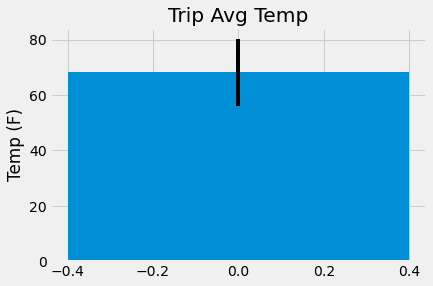

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peak_to_peak = trip_max_temp - trip_min_temp

plt.bar(0, trip_avg_temp, yerr=peak_to_peak)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.savefig("Images/avg_temp_bar.png",bbox_inches="tight", pad_inches=.3)
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.station,
                       Station.name,
                       Station.latitude,
                       Station.longitude,
                       Station.elevation,
                       func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= query_start_date).\
        filter(Measurement.date <= query_end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

trip_rainfall_df = pd.DataFrame(results, columns=['station', 'name', 'latitude', 'longitude', 'elevation', 'precipitation'])
trip_rainfall_df

,station,name,latitude,longitude,elevation,precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.57
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.17
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


### Daily Temperature Average

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Used user input start and end dates

# Use the start and end date to create a range of dates
date_range = []
d_normals_list = []
sdate = trip_start_date
while sdate <= trip_end_date:
 
    date_range.append(sdate)
    
    # Stip off the year and save a list of %m-%d strings
    month_day_str = str(sdate.month).zfill(2) + "-" + str(sdate.day).zfill(2)

    # Loop through the list of %m-%d strings and calculate the normals for each date
    d_m = daily_normals(month_day_str)
    d_normals_list.append(list(np.ravel(d_m)))
    
    sdate = sdate + dt.timedelta(days=1)
d_normals_list

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df = pd.DataFrame(d_normals_list, columns=['min', 'avg', 'max'])
daily_normals_df['date'] = date_range
daily_normals_df.set_index('date', inplace=True)
daily_normals_df

,min,avg,max
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


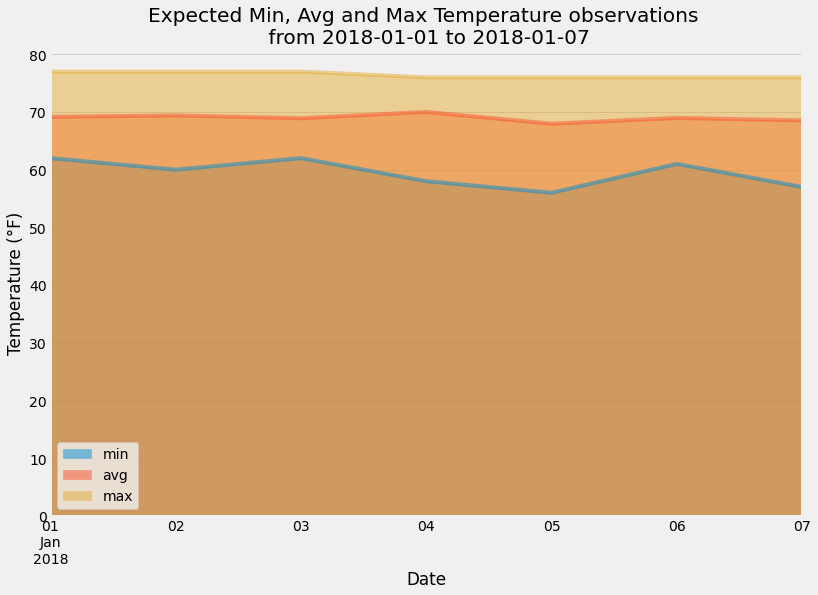

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked=False, figsize=(12,8))
#ax.set_xticks(np.arange(len(daily_normals_df.index)))
#ax.set_xticklabels(daily_normals_df.index, rotation = 45)

plt.title(f"Expected Min, Avg and Max Temperature observations \n from {dt.datetime.strftime(trip_start_date, '%Y-%m-%d')} to {dt.datetime.strftime(trip_end_date, '%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")

plt.savefig("Images/temp_area_chart.png",bbox_inches="tight", pad_inches=.3)

plt.show()